In [84]:
import mykeys

mykeys.initGdriveKeyFile(True)

In [1]:
import mykeys

mykeys.setOsEnv()

아래 링크를 복사하여 웹 브라우저에 붙여넣으세요.
https://accounts.google.com/o/oauth2/auth?client_id=35726703810-4v13dfqmilhgv6shlc3cv9i3ktuh73j1.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code
Authentication successful.
mykey => set HUGGINGFACEHUB_API_TOKEN is done
mykey => set OPENAI_API_KEY is done
mykey => set LANGCHAIN_API_KEY is done
mykey => set LANGCHAIN_HUB_API_KEY is done
mykey => set GOOGLE_API_KEY is done
mykey => set GOOGLE_CSE_ID is done
mykey => set UPSTAGE_API_KEY is done
mykey => set COHERE_API_KEY is done
mykey => set JINA_API_KEY is done
mykey => set ANTHROPIC_API_KEY is done
mykey => set DEEPL_API_KEY is done
mykey => set TAVILY_API_KEY is done
mykey => set TOGETHER_API_KEY is done


In [2]:
# --- 0. 필수 라이브러리 임포트 ---
import os
import pandas as pd
import numpy as np  # .npy 파일 로드를 위해 필요
import io
import json
import re  # 👈 정규식(Regex) 라이브러리 임포트
from typing import List, Set, TypedDict

In [4]:
!pip install sentence_transformers

  Using cached sentence_transformers-5.1.0-py3-none-any.whl.metadata (16 kB)
  Using cached torch-2.8.0-cp310-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached safetensors-0.6.2-cp38-abi3-macosx_11_0_arm64.whl.metadata (4.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached sentence_transformers-5.1.0-py3-none-any.whl (483 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 26.7 MB/s eta 0:00:0031m28.1 MB/s eta 0:00:01
Using cached huggingface_hub-0.34.4-py3-none-any.whl (561 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30

In [6]:
# 머신러닝 및 모델 관련 라이브러리
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline # (기본 라이브러리 임포트 유지)
from google.cloud import vision
from google.oauth2 import service_account  # 👈 직접 인증을 위한 라이브러리

# LangGraph 라이브러리
from langgraph.graph import StateGraph, END

In [7]:
print("--- 🚀 알레르기 분석 서비스 (GCP Vision API + RAG + LLM Fallback) 시작 ---")
print("사전 빌드된 임베딩 캐시 파일을 로드합니다...")

# --- 0a. 표준 알레르기 목록 정의 ---
ALLERGENS_STD_SET = set([
    "알류", "우유", "메밀", "땅콩", "대두", "밀", "잣", "호두",
    "게", "새우", "오징어", "고등어", "조개류", "복숭아", "토마토",
    "닭고기", "돼지고기", "쇠고기", "아황산류"
])
print(f"✅ 표준 알레르기 카테고리 {len(ALLERGENS_STD_SET)}개 로드 완료.")

# --- 0b. 비-성분 키워드 필터 목록 (Node 2 수정용) ---
IGNORE_KEYWORDS = set([
    '열량', '탄수화물', '단백질', '지방', '당류', '나트륨', '콜레스테롤',
    '포화지방', '트랜스지방', '내용량', 'I', 'II' # (빈 문자열 '' 제거된 상태)
])
print(f"✅ 비-성분 필터 키워드 {len(IGNORE_KEYWORDS)}개 로드 완료.")


--- 🚀 알레르기 분석 서비스 (GCP Vision API + RAG + LLM Fallback) 시작 ---
사전 빌드된 임베딩 캐시 파일을 로드합니다...
✅ 표준 알레르기 카테고리 19개 로드 완료.
✅ 비-성분 필터 키워드 12개 로드 완료.


In [8]:

# --- 1. 글로벌 설정: 모델 로드 및 RAG 지식 베이스 캐시 로드 ---
try:
    # 1a. RAG 검색을 위한 임베딩 모델 로드 (쿼리 임베딩용)
    EMBEDDING_MODEL_NAME = 'distiluse-base-multilingual-cased-v1'
    print(f"'{EMBEDDING_MODEL_NAME}' 쿼리 임베딩 모델 로드 중...")
    embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)
    print("✅ 쿼리 임베딩 모델 로드 완료.")

    # 1b. Zero-Shot NLI 모델 로드 (Fallback 전용) - [T5에서 교체됨]
    print("Zero-Shot NLI 모델 로드 중 (Fallback 전용)...")
    NLI_MODEL_NAME = "klue/roberta-base"
    
    # 이전 로그에서 CUDA 사용이 확인되었으므로 device=0 (GPU) 설정
    nli_pipeline = pipeline("zero-shot-classification", model=NLI_MODEL_NAME, device=0) 
    print(f"✅ Zero-Shot NLI 모델 ({NLI_MODEL_NAME}) 로드 완료.")
    
    # NLI Fallback이 사용할 후보 레이블 목록 (글로벌 캐시)
    ALLERGEN_CANDIDATES = list(ALLERGENS_STD_SET) + ["관련 없음"]
    print(f"✅ NLI Fallback 후보 레이블 {len(ALLERGEN_CANDIDATES)}개 준비 완료.")

    # 1c. GCP Vision API 클라이언트 초기화 (직접 경로 지정 방식)
    print("GCP Vision API 클라이언트 (직접 경로 지정) 초기화 중...")
    
    KEY_JSON_PATH = r"20250908_GCP_Service_Credentials.json"

    try:
        credentials = service_account.Credentials.from_service_account_file(KEY_JSON_PATH)
        vision_client = vision.ImageAnnotatorClient(credentials=credentials)
        print(f"✅ GCP Vision 클라이언트 (직접 경로) 준비 완료.")
        
    except FileNotFoundError:
        print(f"❌ 치명적 오류: 지정된 키 파일 경로를 찾을 수 없습니다! 경로를 다시 확인하세요.")
        print(f"   시도한 경로: {KEY_JSON_PATH}")
        raise 
    
    # 1d. 사전 계산된 벡터 캐시 로드
    print("사전 계산된 RAG 지식 베이스 캐시 로드 중...")
    kb_embeddings = np.load("kb_embeddings.npy") 
    
    with open("kb_categories.json", "r", encoding="utf-8") as f:
            kb_categories = json.load(f) 
    
    print(f"✅ RAG 지식 베이스 캐시 로드 완료 ({len(kb_categories)}개 항목)")

except Exception as e:
    print(f"❌ 치명적 오류: 글로벌 설정 실패: {e}")
    exit()

'distiluse-base-multilingual-cased-v1' 쿼리 임베딩 모델 로드 중...


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

✅ 쿼리 임베딩 모델 로드 완료.
Zero-Shot NLI 모델 로드 중 (Fallback 전용)...


config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Device set to use mps:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


✅ Zero-Shot NLI 모델 (klue/roberta-base) 로드 완료.
✅ NLI Fallback 후보 레이블 20개 준비 완료.
GCP Vision API 클라이언트 (직접 경로 지정) 초기화 중...
✅ GCP Vision 클라이언트 (직접 경로) 준비 완료.
사전 계산된 RAG 지식 베이스 캐시 로드 중...
✅ RAG 지식 베이스 캐시 로드 완료 (702개 항목)


In [9]:

# RAG 검색 시 사용할 유사도 임계값 (튜닝된 값으로 가정, 예: 0.85)
# (만약 0.9로 유지하고 NLI가 '유청단백분말'을 잡도록 하려면 0.9로 설정하세요)
RAG_CONFIDENCE_THRESHOLD = 0.85
print(f"ℹ️ RAG 신뢰도 임계값: {RAG_CONFIDENCE_THRESHOLD}")

# NLI Fallback 결과가 유효하다고 인정할 최소 점수
NLI_FALLBACK_THRESHOLD = 0.5  
print(f"ℹ️ NLI Fallback 신뢰도 임계값: {NLI_FALLBACK_THRESHOLD}")

ℹ️ RAG 신뢰도 임계값: 0.85
ℹ️ NLI Fallback 신뢰도 임계값: 0.5


In [ ]:
# --- 2. LangGraph 상태 정의 ---
class AllergyGraphState(TypedDict):
    image_path: str
    raw_ocr_text: str
    ingredients_to_check: List[str]
    current_ingredient: str
    rag_result: dict
    final_allergens: Set[str]
    final_output_json: str
    #TODO 처리단계 오류 발생시 메시지를 담을 공간이 필요함 그래야 화면에 노출 가능

In [ ]:
# --- 3. LangGraph 노드 함수 정의 ---

def call_gcp_vision_api(state: AllergyGraphState) -> AllergyGraphState:
    """
    ✅ 노드 1 (Entry Point): GCP Vision API 호출
    """
    print(f"\n--- (Node 1: call_gcp_vision_api) ---")
    img_path = state['image_path']
    print(f"GCP Vision API 호출... (이미지: {img_path})")
    try:
        with io.open(img_path, 'rb') as image_file:
            content = image_file.read()
        image = vision.Image(content=content)
        
        response = vision_client.text_detection(image=image)
        if response.error.message:
            raise Exception(f"GCP API Error: {response.error.message}")

        raw_text = response.full_text_annotation.text
        print(f"✅ GCP OCR 성공. (추출된 텍스트 길이: {len(raw_text)})")
        return {**state, "raw_ocr_text": raw_text}
    
    except Exception as e:
        print(f"❌ GCP Vision API 처리 실패: {e}")
        return {**state, "raw_ocr_text": ""}
        #TODO 처리가 실패했다면 END로 바로 가는건?

In [ ]:
def parse_text_from_raw(state: AllergyGraphState) -> AllergyGraphState:
    """
    ✅ 노드 2 (Regex 파서 노드)
    (startswith 필터 로직이 적용된 최종 수정 버전)
    """
    print(f"\n--- (Node 2: parse_text_from_raw) [Regex Parser] ---")
    raw_text = state['raw_ocr_text']
    if not raw_text or not raw_text.strip():
        print("ℹ️ OCR 텍스트가 비어있어 파싱을 건너뜁니다.")
        return {**state, "ingredients_to_check": [], "final_allergens": set()}
        #TODO OCR 텍스트가 비어있다면 해당 오류 메시지를 사용자에게 알려주자

    clean_text = raw_text.replace("\n", " ")

    ingredient_queue = []
    found_allergens_set = set()

    match1 = re.search(r"원재료명[ :](.*?)(•|\||영양정보|영양성분|$)", clean_text)
    
    if match1:
        ingredient_blob = match1.group(1).strip()
        raw_ingredients_list = [item.strip() for item in ingredient_blob.split(',') if item.strip()]
        cleaned_ingredients_raw = [name.split('(')[0].strip() for name in raw_ingredients_list if name.strip()]
        
        cleaned_ingredients_filtered = []
        for item in cleaned_ingredients_raw:
            is_noise = False
            for keyword in IGNORE_KEYWORDS:
                if item.startswith(keyword):
                    is_noise = True
                    print(f"  -> 필터링됨: '{item}' (노이즈 키워드 '{keyword}'로 시작하므로 제외)")
                    break 
            
            if not is_noise:
                cleaned_ingredients_filtered.append(item)
        
        ingredient_queue.extend(cleaned_ingredients_filtered)
        print(f"✅ Regex 파서: '원재료명' 섹션에서 {len(cleaned_ingredients_filtered)}개 성분 추출: {cleaned_ingredients_filtered}")
    
    else:
        print("ℹ️ Regex 파서: '원재료명' 섹션을 찾지 못함.")

    match2 = re.search(r"•?\s*([\w,]+)\s+함유", clean_text)
    if match2:
        contains_blob = match2.group(1) 
        contains_list = [item.strip() for item in contains_blob.split(',') if item.strip()]
        print(f"✅ Regex 파서: '...함유' 섹션에서 {len(contains_list)}개 항목 추출: {contains_list}")
        
        for item in contains_list:
            if item not in IGNORE_KEYWORDS:
                ingredient_queue.append(item) 
            
            if item in ALLERGENS_STD_SET:
                print(f"  -> '{item}'은(는) 표준 알레르기이므로 final_set에 직접 추가.")
                found_allergens_set.add(item) 
    else:
        print("ℹ️ Regex 파서: '...함유' 섹션을 찾지 못함.")

    final_queue = sorted(list(set(ingredient_queue)))
    print(f"==> 최종 RAG 검사 큐 (중복제거, {len(final_queue)}개): {final_queue}")
    
    return {
        **state,
        "ingredients_to_check": final_queue,      
        "final_allergens": found_allergens_set 
    }

In [13]:
def prepare_next_ingredient(state: AllergyGraphState) -> AllergyGraphState:
    """
    ✅ 노드 3 (루프 컨트롤러)
    """
    print(f"\n--- (Node 3: prepare_next_ingredient) ---")
    queue = state['ingredients_to_check']
    next_ingredient = queue.pop(0) 
    print(f"다음 검사 대상: '{next_ingredient}' (남은 항목: {len(queue)}개)")
    return {
        **state,
        "current_ingredient": next_ingredient,
        "ingredients_to_check": queue
    }

In [14]:
def rag_search(state: AllergyGraphState) -> AllergyGraphState:
    """
    ✅ 노드 4 (핵심 RAG 검색 노드)
    """
    print(f"--- (Node 4: rag_search) ---")
    ingredient = state['current_ingredient']
    
    query_embedding = embedding_model.encode([ingredient])
    similarities = cosine_similarity(query_embedding, kb_embeddings)
    
    best_match_index = np.argmax(similarities[0])
    confidence_score = float(similarities[0][best_match_index])
    
    found_allergen = kb_categories[best_match_index] 
    
    print(f"RAG 검색: '{ingredient}' (유사도: {confidence_score:.4f}) -> 매핑: '{found_allergen}'")
    
    rag_result_data = {
        "confidence": confidence_score,
        "found_allergen": found_allergen
    }
    return {**state, "rag_result": rag_result_data}

In [15]:
# ==============================================================================
# === 💥 [교체된 노드 5] (Zero-Shot NLI 파이프라인 버전) 💥 ===
# ==============================================================================
def llm_fallback(state: AllergyGraphState) -> AllergyGraphState:
    """
    ✅ 노드 5 (LLM Fallback 노드) - [NLI Zero-Shot 버전]
    
    RAG가 실패한 항목을 Zero-Shot Classification 파이프라인(NLI 모델)으로 넘깁니다.
    입력 성분을 모든 알레르기 후보 레이블과 비교하여 최고 점수(entailment)를 받은 항목을 반환합니다.
    """
    print(f"--- (Node 5: llm_fallback) [NLI Zero-Shot] ---")
    ingredient = state['current_ingredient']
    print(f"NLI Fallback: '{ingredient}' 분류 요청... (후보: {len(ALLERGEN_CANDIDATES)}개)")

    try:
        # NLI 파이프라인 호출 (글로벌 파이프라인 'nli_pipeline' 및 후보 리스트 'ALLERGEN_CANDIDATES' 재사용)
        response = nli_pipeline(ingredient, ALLERGEN_CANDIDATES) 
        
        # 가장 점수가 높은 레이블과 점수를 추출
        top_label = response['labels'][0]
        top_score = response['scores'][0]
        
        print(f"NLI 응답: Label='{top_label}', Score={top_score:.4f}")

        # 최고 점수 레이블이 표준 알레르기 목록(SET)에 있는지 확인
        if top_label in ALLERGENS_STD_SET: 
            # 해당 점수가 우리가 설정한 NLI 임계값(예: 0.5)보다 높은지 확인
            if top_score >= NLI_FALLBACK_THRESHOLD:
                 print(f"  -> 유효한 분류: '{top_label}' (Score: {top_score}, 임계값 {NLI_FALLBACK_THRESHOLD} 통과).")
                 return {**state, "rag_result": {"confidence": top_score, "found_allergen": top_label}}
            else:
                 # 알레르기이긴 하지만, 점수가 너무 낮아서 신뢰할 수 없음
                 print(f"  -> 점수가 낮음 ({top_score} < {NLI_FALLBACK_THRESHOLD}). '없음'으로 처리.")
                 return {**state, "rag_result": {"confidence": 1.0, "found_allergen": "없음"}}
        else:
            # 최고 점수 레이블이 "관련 없음"이거나, (혹시 모를) 다른 쓰레기 값인 경우
            print(f"  -> 최고 점수 레이블이 '{top_label}'이므로 '없음'으로 처리.")
            return {**state, "rag_result": {"confidence": 1.0, "found_allergen": "없음"}}
            
    except Exception as e:
        print(f"❌ NLI Fallback 중 오류: {e}")
        return {**state, "rag_result": {"confidence": 1.0, "found_allergen": "오류"}}
# ==============================================================================
# === [교체된 노드 5] 끝 ===
# ==============================================================================

In [16]:
def update_final_list(state: AllergyGraphState) -> AllergyGraphState:
    """
    ✅ 노드 6 (결과 취합 노드)
    """
    print(f"--- (Node 6: update_final_list) ---")
    result_allergen = state['rag_result']['found_allergen']
    
    if result_allergen in ALLERGENS_STD_SET:
        current_set = state['final_allergens']
        print(f"✅ 유효한 알레르기 발견: '{result_allergen}'. 최종 목록에 추가.")
        current_set.add(result_allergen)
        return {**state, "final_allergens": current_set}
    else:
        print(f"ℹ️ '{result_allergen}'은(는) 표준 알레르기 항목이 아니므로 무시합니다.")
        return state 

In [17]:
def finalize_processing(state: AllergyGraphState) -> AllergyGraphState:
    """
    ✅ 노드 7 (종료 노드)
    """
    print(f"\n--- (Node 7: finalize_processing) ---")
    final_set = state['final_allergens']
    
    final_list = sorted(list(final_set))
    final_json = json.dumps(final_list, ensure_ascii=False)
    
    print(f"🎉 모든 성분 검사 완료. 최종 결과: {final_json}")
    return {**state, "final_output_json": final_json}

In [18]:
# --- 4. LangGraph 엣지(Edge) 함수 정의 ---

def route_rag_result(state: AllergyGraphState) -> str:
    """(조건부 엣지 1: RAG 라우터)
    """
    print(f"--- (Edge: route_rag_result?) ---")
    confidence = state['rag_result']['confidence']
    allergen = state['rag_result']['found_allergen']
    
    if confidence >= RAG_CONFIDENCE_THRESHOLD and allergen in ALLERGENS_STD_SET:
        print(f"  -> [RAG 성공]. 'update_final_list'로 이동.")
        return "rag_success"
    else:
        print(f"  -> [RAG 실패/불확실]. 'llm_fallback'으로 이동.")
        return "needs_llm_fallback"

def check_remaining_ingredients(state: AllergyGraphState) -> str:
    """(조건부 엣지 2: 루프 제어)
    """
    print(f"--- (Edge: check_remaining_ingredients?) ---")
    
    if state["ingredients_to_check"] and len(state["ingredients_to_check"]) > 0:
        print(f"  -> [항목 남음]. 'prepare_next_ingredient'로 루프.")
        return "has_more_ingredients"
    else:
        print("  -> [항목 없음]. 'finalize_processing'로 이동.")
        return "all_ingredients_done"

In [19]:
# --- 5. 그래프 빌드 및 컴파일 ---

print("\n--- LangGraph 워크플로우 빌드 시작 ---")

workflow = StateGraph(AllergyGraphState)

# 1. 모든 노드를 그래프에 추가
workflow.add_node("call_gcp_vision_api", call_gcp_vision_api)
workflow.add_node("parse_text_from_raw", parse_text_from_raw)
workflow.add_node("prepare_next_ingredient", prepare_next_ingredient)
workflow.add_node("rag_search", rag_search)
workflow.add_node("llm_fallback", llm_fallback) # <--- NLI 버전 함수가 등록됨
workflow.add_node("update_final_list", update_final_list)
workflow.add_node("finalize_processing", finalize_processing)

# 2. 엣지 연결 (흐름 정의)
workflow.set_entry_point("call_gcp_vision_api")                
workflow.add_edge("call_gcp_vision_api", "parse_text_from_raw")    
workflow.add_edge("parse_text_from_raw", "prepare_next_ingredient") 
workflow.add_edge("prepare_next_ingredient", "rag_search")          

# 3. RAG 라우팅 (조건부 엣지 1)
workflow.add_conditional_edges(
    "rag_search",
    route_rag_result,
    {"rag_success": "update_final_list", "needs_llm_fallback": "llm_fallback"}
)

# 4. Fallback 결과도 취합 노드로 연결 (NLI Fallback이 연결됨)
workflow.add_edge("llm_fallback", "update_final_list") 

# 5. 메인 루프 (조건부 엣지 2)
workflow.add_conditional_edges(
    "update_final_list",
    check_remaining_ingredients,
    {"has_more_ingredients": "prepare_next_ingredient", "all_ingredients_done": "finalize_processing"}
)

# 6. 종료 노드 연결
workflow.add_edge("finalize_processing", END)

# 7. 컴파일
app = workflow.compile()
print("--- ✅ LangGraph 워크플로우 컴파일 완료 ---")


--- LangGraph 워크플로우 빌드 시작 ---
--- ✅ LangGraph 워크플로우 컴파일 완료 ---


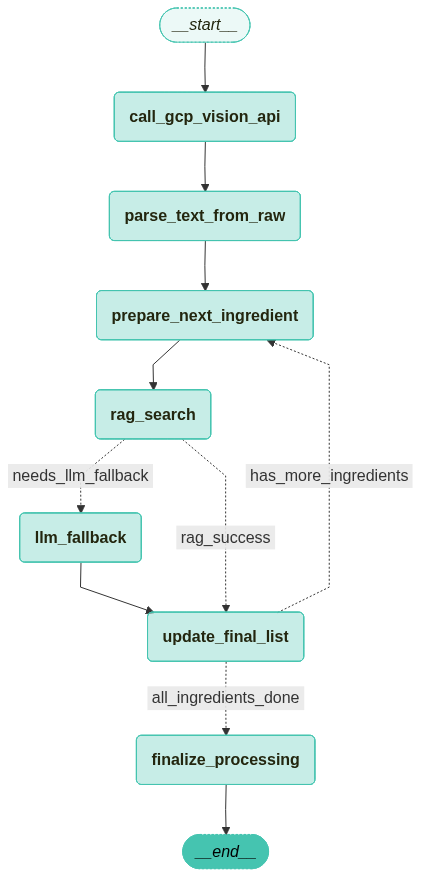

In [20]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(app)

In [21]:

# --- 6. 테스트 실행 ---
print("\n\n--- [Test Run: GCP API + Regex 파서 + NLI Fallback 기반 실행] ---")

# (테스트할 이미지 파일을 지정해야 합니다)
my_test_image_file = "./data_ocr/김광무_142.jpg" # 👈 'image.jpg'는 OCR 로그를 제공한 그 이미지 파일 가정

if my_test_image_file:
    test_input = {"image_path": my_test_image_file}
    print(f"테스트 실행 시작: {my_test_image_file}\n")

    print("\n--- [Test Run: 최종 결과 (invoke)] ---")
    final_state = app.invoke(test_input, {"recursion_limit": 100}) 
    print("\n최종 반환 JSON:")
    print(final_state['final_output_json'])

else:
    print("\n테스트 실행 건너뜀: 'my_test_image_file' 변수에 이미지 경로가 지정되지 않았습니다.")



--- [Test Run: GCP API + Regex 파서 + NLI Fallback 기반 실행] ---
테스트 실행 시작: ./data_ocr/김광무_142.jpg


--- [Test Run: 최종 결과 (invoke)] ---

--- (Node 1: call_gcp_vision_api) ---
GCP Vision API 호출... (이미지: ./data_ocr/김광무_142.jpg)
✅ GCP OCR 성공. (추출된 텍스트 길이: 1008)

--- (Node 2: parse_text_from_raw) [Regex Parser] ---
✅ Regex 파서: '원재료명' 섹션에서 6개 성분 추출: ['및 함량: 대두 100%[외국산', '캐나다', '중국 등)]', '조제해수염화마그네슘', '현미유', '올리브유 대두 함유']
✅ Regex 파서: '...함유' 섹션에서 1개 항목 추출: ['대두']
  -> '대두'은(는) 표준 알레르기이므로 final_set에 직접 추가.
==> 최종 RAG 검사 큐 (중복제거, 7개): ['대두', '및 함량: 대두 100%[외국산', '올리브유 대두 함유', '조제해수염화마그네슘', '중국 등)]', '캐나다', '현미유']

--- (Node 3: prepare_next_ingredient) ---
다음 검사 대상: '대두' (남은 항목: 6개)
--- (Node 4: rag_search) ---
RAG 검색: '대두' (유사도: 0.8702) -> 매핑: '대두'
--- (Edge: route_rag_result?) ---
  -> [RAG 성공]. 'update_final_list'로 이동.
--- (Node 6: update_final_list) ---
✅ 유효한 알레르기 발견: '대두'. 최종 목록에 추가.
--- (Edge: check_remaining_ingredients?) ---
  -> [항목 남음]. 'prepare_next_ingredient'로 루프.

--- (Nod

In [26]:
print(final_state.__repr__())

{'image_path': './data_ocr/김광무_142.jpg', 'raw_ocr_text': '부드럽고 촉촉해서 국물요리에 좋은\n찌개두부\n.\n•포장재질(내면): 폴리에틸렌(리드지), 폴리프로필렌(용기)\n양념이 쏙 배는\n찌개용\n조리예\nww\n냉장\n보관\n0~10℃\n無첨가\n290g\n"안전관리인증\nHACCP\n거품제거제(규소수지),\n유화제글리세린지방산에스테르) (247kcal)\n식품의약품안전처\n.\n• 제품명 : 찌개두부 · 식품유형 : 두부 · 제조원 : F2-㈜피피이씨의령/경남 의령군 부림면 한지20길 40-21,\nF3-풀무원식품주/충북 음성군 대소면 대소산단로 58. FS-서신식품(주)/충북 음성군 맹동면 맹동산단로 62\n• 원재료명 및 함량: 대두 100%[외국산(미국, 캐나다, 중국 등)], 조제해수염화마그네슘,\n현미유, 올리브유 대두 함유 • 품목보고번호: F2-1995061600622, F3-2003044504525,\nFS-201104450381•유통전문판매원 : 풀무원식품(주)/충북 음성군 대소면 삼양로 730-27\n총내용량 290g\n영양정보\n.\n•이 용기는 재활용이 가능합니다. • 보관방법 : 냉장보관(0~10℃)\n•사용상주의: 개봉 후 냉장보관하 거나 빨리 드시기 바랍니다..\n반품 및 교환: 본사 및 구입처 • 본 제품은 공정거래위원회 고시 소비자 분쟁 해결\n기준에 의거 교환 또는 보상을 받으실 수 있습니다. . 고객 기쁨센터: 080-022-\n비닐류\n0085• 풀무원은 고객의 의견을 존중합니다. • 부정·불량식품 신고는 국번없이 리드: OTHER / 용기:PP\n1399 • www.pulmuone.kr\n소비 2025.09.12 F2 까지\n100g당 85 kcal 기한\n나트륨 10mg 1% 탄수화물 1g0% 당류 1g 미만 1% 식이섬유 1g 미만3%\n지방6g 11% 트랜스지방 0g 포화지방1g7% 콜레스테롤 0mg 0%\n단백질 7g 13% 칼슘 31mg4% 철분 1.2m

In [32]:
import json
import ast

# 원본 텍스트
ugly_data_string = final_state.__repr__()

# 문자열을 딕셔너리로 변환
data_dict = ast.literal_eval(ugly_data_string)

# `final_allergens` 값을 set에서 list로 변환
data_dict['final_allergens'] = list(data_dict['final_allergens'])

# 이제 JSON으로 변환 가능
pretty_json_string = json.dumps(data_dict, indent=2, ensure_ascii=False)

print(pretty_json_string)

{
  "image_path": "./data_ocr/김광무_142.jpg",
  "raw_ocr_text": "부드럽고 촉촉해서 국물요리에 좋은\n찌개두부\n.\n•포장재질(내면): 폴리에틸렌(리드지), 폴리프로필렌(용기)\n양념이 쏙 배는\n찌개용\n조리예\nww\n냉장\n보관\n0~10℃\n無첨가\n290g\n\"안전관리인증\nHACCP\n거품제거제(규소수지),\n유화제글리세린지방산에스테르) (247kcal)\n식품의약품안전처\n.\n• 제품명 : 찌개두부 · 식품유형 : 두부 · 제조원 : F2-㈜피피이씨의령/경남 의령군 부림면 한지20길 40-21,\nF3-풀무원식품주/충북 음성군 대소면 대소산단로 58. FS-서신식품(주)/충북 음성군 맹동면 맹동산단로 62\n• 원재료명 및 함량: 대두 100%[외국산(미국, 캐나다, 중국 등)], 조제해수염화마그네슘,\n현미유, 올리브유 대두 함유 • 품목보고번호: F2-1995061600622, F3-2003044504525,\nFS-201104450381•유통전문판매원 : 풀무원식품(주)/충북 음성군 대소면 삼양로 730-27\n총내용량 290g\n영양정보\n.\n•이 용기는 재활용이 가능합니다. • 보관방법 : 냉장보관(0~10℃)\n•사용상주의: 개봉 후 냉장보관하 거나 빨리 드시기 바랍니다..\n반품 및 교환: 본사 및 구입처 • 본 제품은 공정거래위원회 고시 소비자 분쟁 해결\n기준에 의거 교환 또는 보상을 받으실 수 있습니다. . 고객 기쁨센터: 080-022-\n비닐류\n0085• 풀무원은 고객의 의견을 존중합니다. • 부정·불량식품 신고는 국번없이 리드: OTHER / 용기:PP\n1399 • www.pulmuone.kr\n소비 2025.09.12 F2 까지\n100g당 85 kcal 기한\n나트륨 10mg 1% 탄수화물 1g0% 당류 1g 미만 1% 식이섬유 1g 미만3%\n지방6g 11% 트랜스지방 0g 포화지방1g7% 콜레스테롤 0mg 0%\n단백질 7g 13% 칼슘 31mg4% 철

In [24]:
print(dir(final_state))

['__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']


In [34]:
!pip install gradio

  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached fastapi-0.116.1-py3-none-any.whl.metadata (28 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached uvicorn-0.35.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 MB 36.3 MB/s eta 0:00:00m eta 0:00:010:00:01
Using cached aiofiles-24.1.0-py3-none-any.whl (15 kB)
Using cached fastapi-0.116.1-py3-none-any.whl (95 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.0/873.0 kB 32.3 MB/s eta 0:00:00
Using cached python_multipart-0.0.20-py3-none-any.whl (24 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 38.9 MB/s eta 0:00:00MB/s eta 0:00:01
Using cached shellingham-1.5.4-py2.py3-none-any.whl (9.8 kB)
Using cached uvicorn-0.35.0-py3-none-any.whl (66 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18/18 [gradio];5;237m━━ 17/18 [gradio]]


In [35]:
import gradio as gr
from PIL import Image

def process_image(image):
    """
    This function takes a PIL Image object as input and returns a modified image.
    For demonstration, it simply returns the input image.
    """
    if image is None:
        return None
    # Example: You could perform image processing here, e.g., resizing, filtering
    # resized_image = image.resize((100, 100))
    return image

# Create a Gradio interface
iface = gr.Interface(
    fn=process_image,
    inputs=gr.Image(type="pil", label="Upload an Image"),  # Input component for image upload
    outputs=gr.Image(type="pil", label="Processed Image"),  # Output component to display image
    title="Gradio Image Upload Example"
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
